In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml
import matplotlib.patches as mpatches

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions23 import *

fatal: not a git repository (or any parent up to mount point /)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [2]:
# Define paths
local = 0 #Set to 0 when working on server
paths = path(local)
config='/home/jvalenti/MOAD/analysis-jose/OParcels/SalishSea_Population2.yaml'

In [3]:
def load_config(config_yaml):
   with open(config_yaml) as f:
       config = yaml.safe_load(f)
   return config

In [4]:
def loadyamls(config):
    param = load_config(config)
    start = datetime(param['startdate']['year'], param['startdate']['month'], param['startdate']['day']) #Start date
    Tmax = param['param']['length'] # Set Time length [days] 
    duration = timedelta(days=Tmax)
    dt = param['param']['dt'] #toggle between - or + to pick backwards or forwards 
    N = param['param']['N'] # number of deploying locations
    n = param['param']['n'] # 1000   # number of particles per location
    dmin = param['param']['dmin'] #minimum depth
    dd = param['param']['dd'] #max depth difference from dmin
    name = param['file']['name'] #name output file
    daterange = [start+timedelta(days=i) for i in range(Tmax)]
    fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
    outfile = os.path.join(paths['out'], fn)
    MFc = param['param']['MFc']
    return outfile, MFc

In [5]:
outfile, MFc=loadyamls(config)
coords=xr.open_dataset(paths['coords'],decode_times=False)
ds = xr.open_dataset(outfile)
#DS=ds.to_dataframe()
time=ds.time[0]
mask = xr.open_dataset(paths['mask'])


#dss=ds[ds.beached==0]## In the water column
dssla=ds.lat
dsslo=ds.lon
dsscon= float(MFc)
dssdep=ds.z


In [6]:
def order_data_bytime(data):  #Here we encapsulate everything that happens at the same time together (It is easier to animate this way) 
    '''Change to use your variables of interest'''
    DS = data.to_dataframe()
    DS=DS[DS.beached==0]
    lon = np.array(DS.sort_values(by='time').lon)
    lat = np.array(DS.sort_values(by='time').lat)
    z = np.array(DS.sort_values(by='time').z)
    age = np.array(DS.sort_values(by='time').tau)/3600
    T = np.array(DS.sort_values(by='time').time)

    Tint = []
    for ti in T:
        try:
            Tint.append(int(ti)) 
        except TypeError: 
            pass
            
    Tint = np.array(Tint)
    Age = []
    Z = []
    Lat = []
    Lon = []
    t = time[0]
    while int(t) < int(time[-1]): 
        Lat.append(lat[np.where(Tint==int(t))])
        Lon.append(lon[np.where(Tint==int(t))])
        Age.append(age[np.where(Tint==int(t))])
        Z.append(z[np.where(Tint==int(t))])
        t+=np.timedelta64(72, 'h')

    return Lat,Lon,Age,Z

In [7]:
vol=xr.open_dataset('/home/jvalenti/MOAD/grid2/grid/mesh_maskBV201702.nc')['volume_cell']

outfile, MFc=loadyamls(config)
coords=xr.open_dataset(paths['coords'],decode_times=False)
ds = xr.open_dataset(outfile)
time=ds.time[0]
dssla,dsslo,Age,dssdep = order_data_bytime(ds)
dsscon= float(MFc)
conc=np.zeros((time.shape[0],coords.nav_lon.shape[0],coords.nav_lon.shape[1],mask.gdepw_0.shape[1]))
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
arr = mask.gdepw_0[0,:,240,340]

for t in range(len(dssla)):
    if t%2==0:
        print(f'{100*t/len(time):.2f}% done.')
    for i in range(len(dssla[t])):
        jj = jjii.jj.sel(lats=dssla[t][i], lons=dsslo[t][i], method='nearest').item()
        ii = jjii.ii.sel(lats=dssla[t][i], lons=dsslo[t][i], method='nearest').item()
        try:
            dep = (np.abs(arr - dssdep[t][i])).argmin()
            if arr[dep] > dssdep[t][i]:
                dep+=-1
            conc[t,jj,ii,dep] += dsscon/vol[0,dep,jj,ii].item()
        except ValueError:
            pass
    
data_set=xr.Dataset(coords={'time':time,'lat': (['x', 'y'], coords.nav_lat.data),
                'lon': (['x', 'y'], coords.nav_lon.data),'depth':arr})
data_set["Prob"]=(['t','x', 'y','z'], conc)
param = load_config(config)
data_set.load().to_netcdf(path='/home/jvalenti/MOAD/results/'+param['file']['name']+'_prob'+str(param['startdate']['year'])+'.nc')

0.00% done.
3.92% done.
7.84% done.
11.76% done.
15.69% done.
19.61% done.
23.53% done.
27.45% done.
31.37% done.
35.29% done.
39.22% done.
43.14% done.
47.06% done.
50.98% done.
54.90% done.
58.82% done.
62.75% done.
66.67% done.
70.59% done.
74.51% done.
78.43% done.
82.35% done.
86.27% done.
90.20% done.
94.12% done.


In [13]:
param = load_config(config)
cend1 = xr.open_dataset('/home/jvalenti/MOAD/results/'+param['file']['name']+'_prob'+str(param['startdate']['year'])+'.nc').Prob

In [14]:
cend1

<xarray.DataArray 'Prob' (t: 51, x: 898, y: 398, z: 40)>
[729104160 values with dtype=float64]
Coordinates:
    lat      (x, y) float32 ...
    lon      (x, y) float32 ...
    depth    (z) float32 ...
Dimensions without coordinates: t, x, y, z

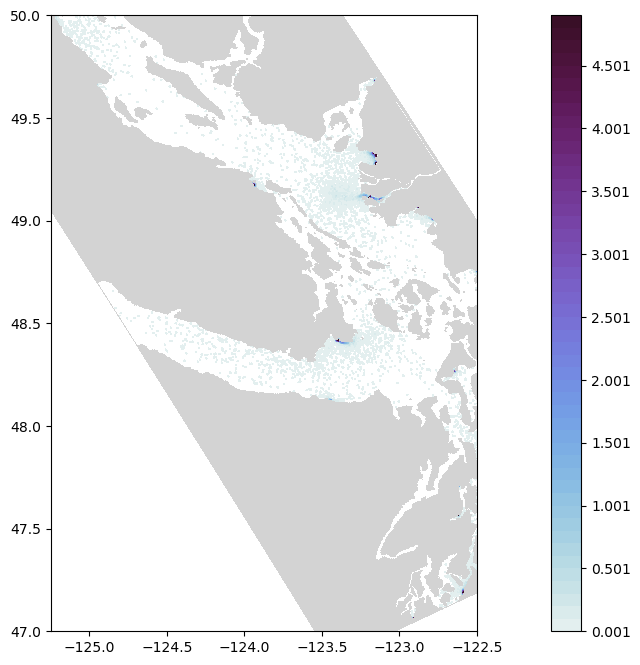

In [19]:
z = mask.gdepw_0[0,:,240,340]
#cend=conc*0.01*(2118/5)*(2*3600/2.6e6)/2
#cend1=(conc1*0.01*(2118/5)*(2*3600/2.6e6)/2)-cend
#cend2=conc2*0.01*(2118/5)*(2*3600/2.6e6)/2
# cend3=conc3*0.1*(2118/5)*(2*3600/2.6e6)

fig = plt.figure(figsize=(19, 8))
#axs = plt.axes(xlim=(-123.25,-122.8),ylim=(49,49.25))
axs=plt.axes(xlim=(-125.25,-122.5),ylim=(47,50))

levels = np.linspace(1,800,50)

colors = list(cmocean.cm.dense(np.linspace(0,1,len(levels)-1)))
colors[-1] = "red"
cmap = matplotlib.colors.ListedColormap(colors,"", len(colors))


# #axs.contourf(coords.nav_lon, coords.nav_lat, mask.bathym[0,:,:],levels=np.arange(0,400,10),cmap=cmocean.cm.deep,alpha=1)
a=axs.contourf(coords.nav_lon, coords.nav_lat, np.sum(np.sum(cend1[:,:,:,0:20],axis=0),axis=2)/(2*510),levels=np.arange(1e-3,5,0.1),cmap=cmocean.cm.dense)
 #axs.scatter(frs_lon,frs_lat)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')

# #axs.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
plt.colorbar(a)

axs.set_aspect(1/np.sin(np.deg2rad(49)))

NameError: name 'cend' is not defined

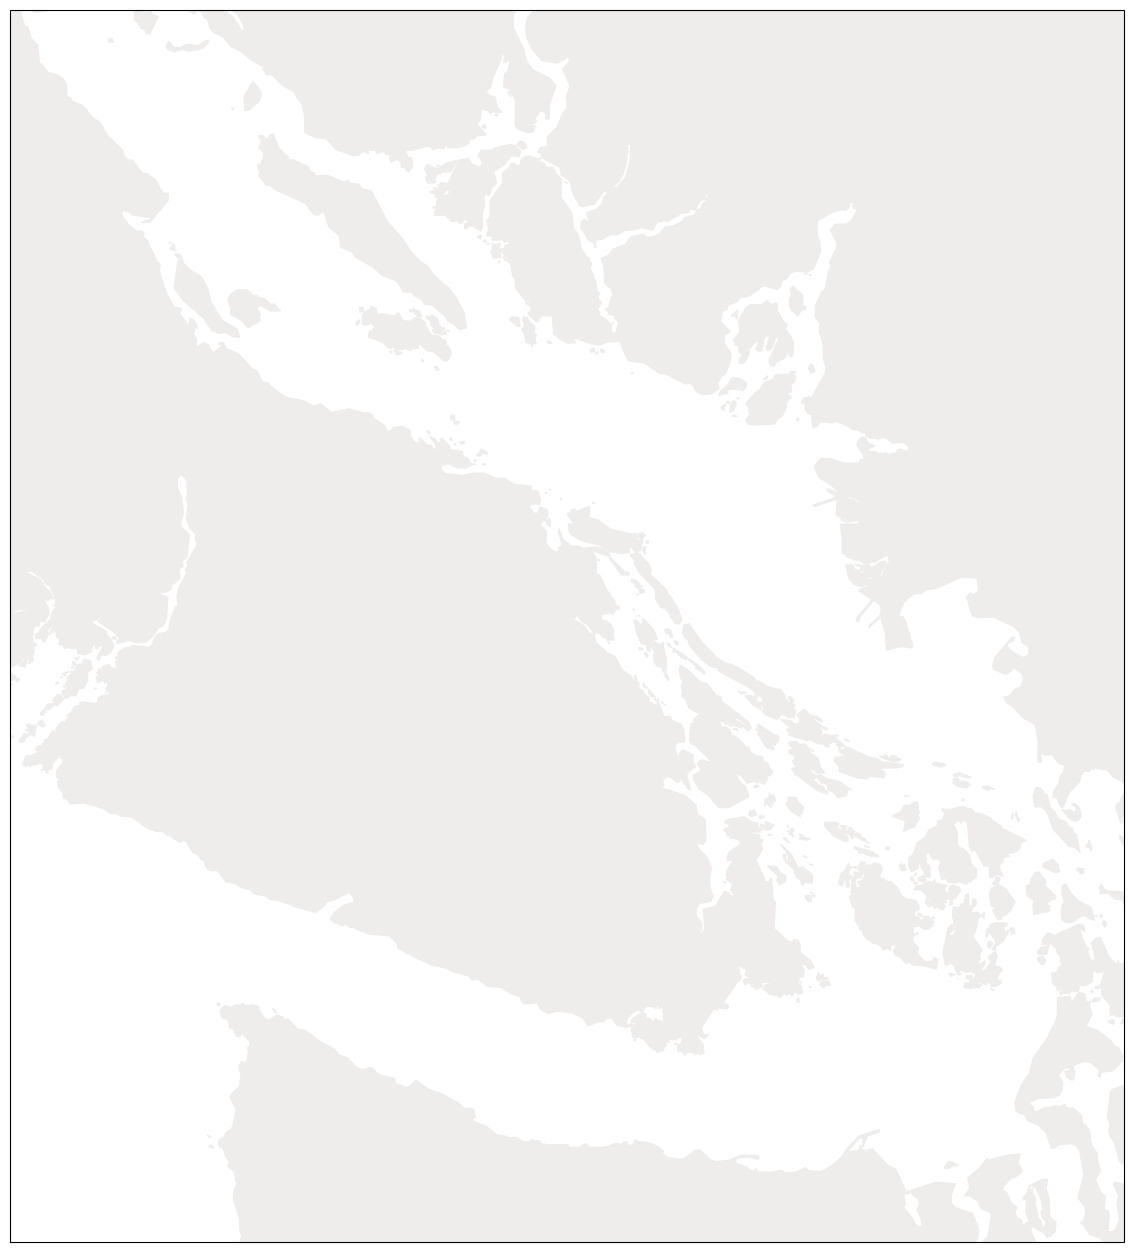

In [10]:
# Make map
fig, ax = plt.subplots(figsize=(38, 16), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([-125.25, -122.5, 48, 50], crs=crs.PlateCarree())

ax.add_feature(feature.GSHHSFeature('high', facecolor='#EEEDEC',edgecolor='#EEEDEC'),zorder=2)
im=ax.contourf(coords.nav_lon, coords.nav_lat, cend[:,:,0],transform=crs.PlateCarree(),levels=np.arange(1,25,1),cmap=cmap,extend='max')

gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=[-125,-124,-123,-122], ylocs=[48.5,49,49.5],zorder=5)
gl.top_labels, gl.right_labels = False, False

cbar = fig.colorbar(im, location='bottom',aspect=60,shrink=0.3,pad=0.05)

cbar.set_label('MP concentration')

ax.add_patch(mpatches.Rectangle(xy=[-124,49.3], width=0.2, height=0.1,
                                    facecolor=(245/255, 255/255, 40/255),
                                    alpha=0.5,
                                    transform=crs.PlateCarree(),zorder=5)
                 )
ax.add_patch(mpatches.Rectangle(xy=[-123.3,49.1], width=0.1, height=0.26,
                                    facecolor='green',
                                    alpha=0.5,
                                    transform=crs.PlateCarree(),zorder=5)
                 )
ax.add_patch(mpatches.Rectangle(xy=[-123.2,49.1], width=0.04, height=0.03,
                                    facecolor='black',
                                    alpha=0.5,
                                    transform=crs.PlateCarree(),zorder=5)
                 )

# ax.add_patch(mpatches.Rectangle(xy=[-123.5,48.25], width=0.2, height=0.1,
#                                     facecolor='black',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
#                  )

# ax.add_patch(mpatches.Rectangle(xy=[-123.35,48.5], width=0.2, height=0.1,
#                                     facecolor='black',
#                                     alpha=0.5,
#                                     transform=crs.PlateCarree(),zorder=5)
                #  )

ax.text(-0.05, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")
ax.text(0.5, -0.05, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")

In [ ]:
vol=xr.open_dataset('/home/jvalenti/MOAD/grid/grid/mesh_maskBV201702.nc')['volume_cell']
def get_conc(latmin,latmax,lonmin,lonmax, conc):
    jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
    j = [jjii.jj.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    i = [jjii.ii.sel(lats=latmin, lons=lonmin, method='nearest').item()]
    j.append(jjii.jj.sel(lats=latmin, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmin, lons=lonmax, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmin, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmin, method='nearest').item())
    j.append(jjii.jj.sel(lats=latmax, lons=lonmax, method='nearest').item())
    i.append(jjii.ii.sel(lats=latmax, lons=lonmax, method='nearest').item())
    a=[min(j),max(j),min(i),max(i)]
    Len = (a[1]-a[0])*(a[3]-a[2])
    SD = []
    Mean = []
    for ki in range(len(z)):
        values = []
        vols = []
        for j in range(a[0],a[1],1):
            for i in range(a[2],a[3],1):
                values.append(conc[j,i,ki])
                vols.append(vol[0,ki,j,i])
        values = np.array(values)
        vols = np.array(vols)
        Mean.append(np.sum(values)/np.sum(vols))
        valuess = np.divide(values,vols)
        SD.append(np.std(valuess)/np.sqrt(Len))
    return Mean,SD

In [ ]:
jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
[jjii.ii.sel(lats=48.520555, lons=-123.238390, method='nearest').item()] 
#[jjii.jj.sel(lats=48.520555, lons=-123.238390, method='nearest').item()]

[229]

In [ ]:
def MP_measur(ax,RES):
    Fraser_MP = RES.iloc[:,[1,7,13,19,25]]
    Fraser_SE = RES.iloc[:,[2,8,14,20,26]]
    Lori_MP = RES.iloc[:,[3,9,15,21,27]]
    Lori_SE = RES.iloc[:,[4,10,16,22,28]]
    SoG_MP = RES.iloc[:,[5,11,17,23,29]]
    SoG_SE = RES.iloc[:,[6,12,18,24,30]]
    label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']
    for i in range(5):
        ax[1].errorbar(Lori_MP.iloc[:,i], -z, xerr = Lori_SE.iloc[:,i],label=label[i])
        ax[0].errorbar(Fraser_MP.iloc[:,i], -z, xerr = Fraser_SE.iloc[:,i],label=label[i])
        ax[2].errorbar(SoG_MP.iloc[:,i], -z, xerr = SoG_SE.iloc[:,i],label=label[i])
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_ylim(-20,0.5)
    ax[1].set_ylim(-20,0.5)
    ax[2].set_ylim(-20,0.5)
    return 

In [ ]:
# RES = pd.read_csv('results.csv')
# fig,axs=plt.subplots(1,3,figsize=(15,10))
# MP_measur(axs,RES)
# axs[0].set_title('MP concentration in the Fraser')
# axs[1].set_title("MP concentration Lori's sampling area")
# axs[2].set_title('MP concentration in the SoG')


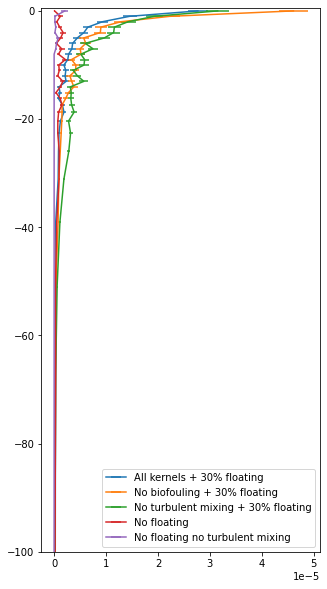

In [ ]:
def MP_measure2(ax,conc,label): 
    Fraser_MP,Fraser_SE=get_conc(48.5,48.6,-123.35,-123.15,conc)

    ax.errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax.legend()
    ax.set_ylim(-100,0.5)

fig,axs=plt.subplots(1,1,figsize=(5,10))
label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']

MP_measure2(axs,conc,label[0])
MP_measure2(axs,conc1,label[1])
MP_measure2(axs,conc2,label[2])
MP_measure2(axs,conc3,label[3])
MP_measure2(axs,conc4,label[4])

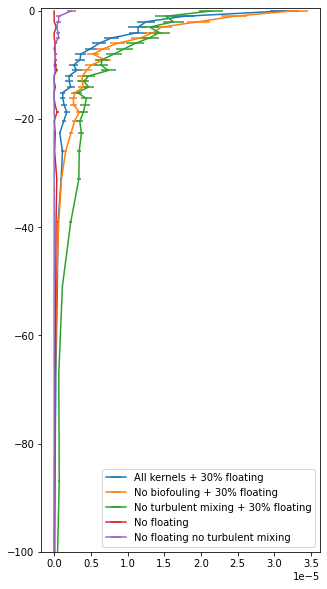

In [ ]:
def MP_measure2(ax,conc,label):
    Fraser_MP,Fraser_SE=get_conc(48.25,48.35,-123.5,-123.3,conc)

    ax.errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax.legend()
    ax.set_ylim(-100,0.5)
    


fig,axs=plt.subplots(1,1,figsize=(5,10))
label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']

MP_measure2(axs,conc,label[0])
MP_measure2(axs,conc1,label[1])
MP_measure2(axs,conc2,label[2])
MP_measure2(axs,conc3,label[3])
MP_measure2(axs,conc4,label[4])

In [ ]:
def MP_measure(ax,conc,label):
    Fraser_MP,Fraser_SE=get_conc(49.1,49.13,-123.2,-123.16,conc)
    SoG_MP,SoG_SE =get_conc(49.3,49.4,-124,-123.8,conc)
    Lori_MP,Lori_SE =get_conc(49.1,49.36,-123.3,-123.2,conc)
    ax[1].errorbar(Lori_MP, -z, xerr = Lori_SE,label=label)
    ax[0].errorbar(Fraser_MP, -z, xerr = Fraser_SE,label=label)
    ax[2].errorbar(SoG_MP, -z, xerr = SoG_SE,label=label)
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[0].set_ylim(-20,0.5)
    ax[1].set_ylim(-20,0.5)
    ax[2].set_ylim(-20,0.5)
    return Fraser_MP,Fraser_SE, Lori_MP,Lori_SE,SoG_MP,SoG_SE

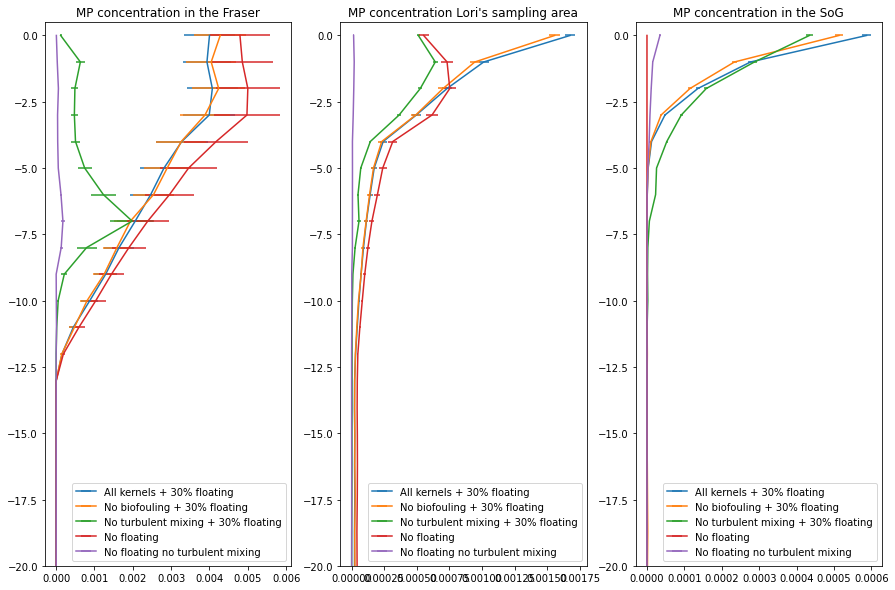

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(15,10))
label = ['All kernels + 30% floating','No biofouling + 30% floating','No turbulent mixing + 30% floating','No floating','No floating no turbulent mixing']

F1,FE1,L1,LE1,S1,SE1=MP_measure(axs,conc,label[0])
F2,FE2,L2,LE2,S2,SE2=MP_measure(axs,conc1,label[1])
F3,FE3,L3,LE3,S3,SE3=MP_measure(axs,conc2,label[2])
F4,FE4,L4,LE4,S4,SE4=MP_measure(axs,conc3,label[3])
F5,FE5,L5,LE5,S5,SE5=MP_measure(axs,conc4,label[4])
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[2].set_title('MP concentration in the SoG')
dict = {'F1':F1,'FE1':FE1,'L1':L1,'LE1':LE1,'S1':S1,'SE1':SE1,'F2':F2,'FE2':FE2,'L2':L2,'LE2':LE2,'S2':S2,'SE2':SE2,'F3':F3,'FE3':FE3,'L3':L3,'LE3':LE3,'S3':S3,'SE3':SE3,'F4':F4,'FE4':FE4,'L4':L4,'LE4':LE4,'S4':S4,'SE4':SE4,'F5':F5,'FE5':FE5,'L5':L5,'LE5':LE5,'S5':S5,'SE5':SE5}
df = pd.DataFrame(dict) 
df.to_csv('resultsnSummer5.csv')

Text(0.5, 1.0, 'MP concentration in the SoG')

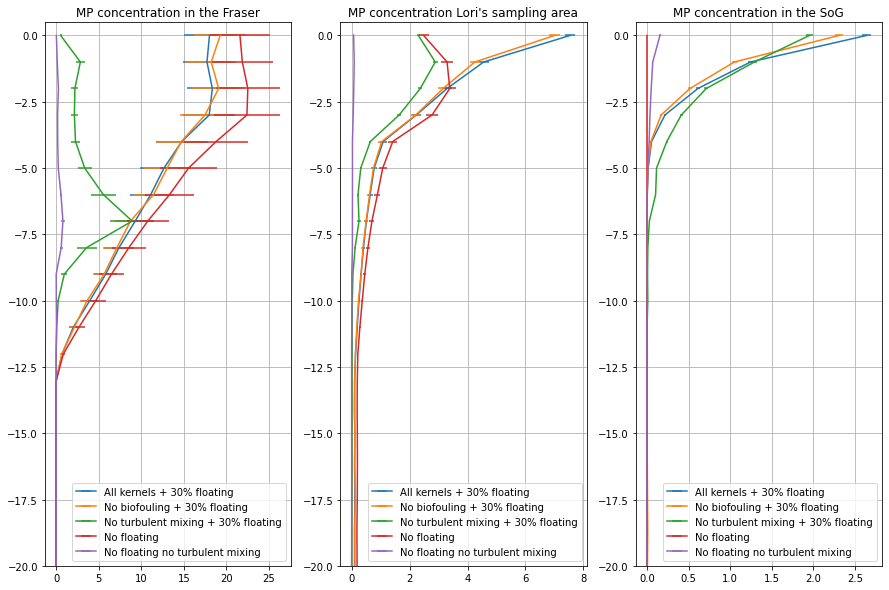

In [ ]:
RES = pd.read_csv('resultsnSummer5.csv')*4500
fig,axs=plt.subplots(1,3,figsize=(15,10))
MP_measur(axs,RES)
axs[0].set_title('MP concentration in the Fraser')
axs[1].set_title("MP concentration Lori's sampling area")
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[2].set_title('MP concentration in the SoG')

In [ ]:
# RES = pd.read_csv('resultsn.csv')*4500
# fig,axs=plt.subplots(1,3,figsize=(15,10))
# MP_measur(axs,RES)
# axs[0].set_title('MP concentration in the Fraser')
# axs[1].set_title("MP concentration Lori's sampling area")
# axs[0].grid()
# axs[1].grid()
# axs[2].grid()
# axs[2].set_title('MP concentration in the SoG')

In [ ]:
# dW = np.random.normalvariate(0, sqrt(particle.dt)) 
# wprime = Kzdz + (sqrt(2*Kz)*dW)/particle.dt 
# dzp = wprime*particle.dt

In [ ]:
# fig = plt.figure(figsize=(19, 8))
# anim = mapanimationd(conc,clon,clat,fps=1)
# f = r"/home/jvalenti/MOAD/animations/Fraser2.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [ ]:
#  with open(f,'rb') as anim:
#     display(Image(anim.read()))